---
title: "Saudi Dialects Classifier"
author: "Turki Alsaedi"
html:
    toc: true
    toc-depth: 2
    toc-location: left
    title-block-banner: true
    title-block-banner: "header.jpg"
jupyter: python3
---

## About
A supervised ANN model that takes a given text and classifies it into one of Saudi Arabia's main regional dialects.

## Background and Goal
Saudi Arabia is one of the biggest countries in the world and thus has many regions each with it own dialect. Classifying a given text into its corresponding dialect can help better understand the meaning of the text and ideally help enable replying in the same dialect.

## Loading Libraries and Data

In [35]:
import numpy as np
import pandas as pd

import re
import pyarabic.araby as araby

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt

In [36]:
data = pd.read_csv("data/data.csv")

In [37]:
data = data[["Embedded_text", "dialect"]]

In [38]:
data
# H: Hijazi
# N: Najdi
# E: Eastern
# S: Southern
# W: White

,Embedded_text,dialect
0,بموت ، ايش هادا الغزل الرخيص ؟ ، بس معليش صادق...,H
1,ياربي معاتيه كل واحد يسوي مصيبه يزغرط يركب حصا...,W
2,ياروحي تتاكل ماشاء الله عليها، الله يحفظها ويخ...,H
3,جديًا هادا الاداء يفوز بقلبي اقسم بالله ، اتمن...,H
4,. https://twitter.com/bbhsparkles/status/99860...,NaN
...,...,...
5245,والغلط فالنهاية عليا انا,H
5246,الدُنيا بادية معايا تحدي ودي المرة بالقوي,H
5247,م كنت افهم لمن بعض الناس يغردو و يقولو النوم س...,H
5248,امـي هيا الشخص الوحيد الي اخوض معاها نقاش وادر...,H


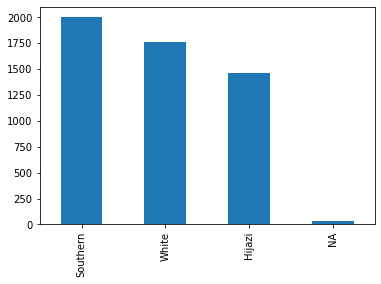

In [39]:
ax = data["dialect"].value_counts(dropna=False).plot(kind='bar')
ax.set_xticklabels(["Southern", "White", "Hijazi", "NA"]);

In [40]:
data = data.dropna()
data

,Embedded_text,dialect
0,بموت ، ايش هادا الغزل الرخيص ؟ ، بس معليش صادق...,H
1,ياربي معاتيه كل واحد يسوي مصيبه يزغرط يركب حصا...,W
2,ياروحي تتاكل ماشاء الله عليها، الله يحفظها ويخ...,H
3,جديًا هادا الاداء يفوز بقلبي اقسم بالله ، اتمن...,H
7,Replying to \n@Layan_sami\nالوانها واشكالها تف...,W
...,...,...
5245,والغلط فالنهاية عليا انا,H
5246,الدُنيا بادية معايا تحدي ودي المرة بالقوي,H
5247,م كنت افهم لمن بعض الناس يغردو و يقولو النوم س...,H
5248,امـي هيا الشخص الوحيد الي اخوض معاها نقاش وادر...,H


## Pre-processing tweets
1. Remove any non-Arabic text
2. Remove repeated characters
3. Remove Arabicc diacritics (haraket, tatweel and hamza)
4. Correct some spelling mistakes

In [41]:
# Removing any non-Arabic words/characters (English, emojis, special characters, etc...)
txt = "جديًا هادا الاداء يفوز ب قلبــــي اقسم بالله ، اتمنننننى انهم يرجعو يأدوه https://twitter.com/eklmre/status/999684853468626944… This Tweet is unavailab"
x = re.findall("[\u0621-\u064A]+", txt)
x = ' '.join(x)
x

'جدي ا هادا الاداء يفوز ب قلبــــي اقسم بالله اتمنننننى انهم يرجعو يأدوه'

In [42]:
# Remove repeated characters
re.sub(r'(.)\1+', r'\1', txt)

'جديًا هادا الاداء يفوز ب قلبـي اقسم باله ، اتمنى انهم يرجعو يأدوه htps:/twiter.com/eklmre/status/968485346862694… This Twet is unavailab'

In [43]:
# Remove diacritics and tatweel and hamza
araby.strip_tashkeel(txt)

'جديا هادا الاداء يفوز ب قلبــــي اقسم بالله ، اتمنننننى انهم يرجعو يأدوه https://twitter.com/eklmre/status/999684853468626944… This Tweet is unavailab'

In [44]:
araby.strip_tatweel(txt)

'جديًا هادا الاداء يفوز ب قلبي اقسم بالله ، اتمنننننى انهم يرجعو يأدوه https://twitter.com/eklmre/status/999684853468626944… This Tweet is unavailab'

In [45]:
# Fix incorrect spelling
txt.replace(" ب ", " ب")

'جديًا هادا الاداء يفوز بقلبــــي اقسم بالله ، اتمنننننى انهم يرجعو يأدوه https://twitter.com/eklmre/status/999684853468626944… This Tweet is unavailab'

In [46]:
txt.replace(" م ", " ما ")

'جديًا هادا الاداء يفوز ب قلبــــي اقسم بالله ، اتمنننننى انهم يرجعو يأدوه https://twitter.com/eklmre/status/999684853468626944… This Tweet is unavailab'

In [47]:
# unify Taa marbuta to avoid different spelling
txt.replace("ة", "ه")

'جديًا هادا الاداء يفوز ب قلبــــي اقسم بالله ، اتمنننننى انهم يرجعو يأدوه https://twitter.com/eklmre/status/999684853468626944… This Tweet is unavailab'

In [48]:
araby.normalize_hamza(txt)

'جديًا هادا الاداء يفوز ب قلبــــي اقسم بالله ، اتمنننننى انهم يرجعو يءدوه https://twitter.com/eklmre/status/999684853468626944… This Tweet is unavailab'

In [49]:
def process_text(txt):
    txt = araby.strip_tashkeel(txt)
    txt = txt.replace(" م ", " ما ")
    txt = txt.replace("ة", "ه")
    for l in ["ب", "ف", "و", "ك","ما"]:
        if f" {l} " in txt:
            txt = txt.replace(f" {l} ", f" {l}")
    txt = re.findall("[\u0621-\u064A]+", txt)
    txt = ' '.join(txt) 
    txt = re.sub(r'(.)\1+', r'\1', txt)
    txt = araby.strip_tatweel(txt)
    txt = araby.normalize_hamza(txt)
    return txt

In [50]:
# Example
print("ORIGINAL TEXT\n" + txt + "\n")
print("PROCESSED TEXT\n"+ process_text(txt))

ORIGINAL TEXT
جديًا هادا الاداء يفوز ب قلبــــي اقسم بالله ، اتمنننننى انهم يرجعو يأدوه https://twitter.com/eklmre/status/999684853468626944… This Tweet is unavailab

PROCESSED TEXT
جديا هادا الاداء يفوز بقلبي اقسم باله اتمنى انهم يرجعو يءدوه


In [ ]:
data["Embedded_text"] = data["Embedded_text"].apply(process_text)

In [52]:
# English-only text get converted to "" i.e.  empty string, this 
# function coverts it to NA then drop it using dropna()
data = data.replace('', np.nan).dropna()
data

,Embedded_text,dialect
0,بموت ايش هادا الغزل الرخيص بس معليش صادقه واله...,H
1,ياربي معاتيه كل واحد يسوي مصيبه يزغرط يركب حصا...,W
2,ياروحي تاكل ماشاء اله عليها اله يحفظها ويخليها...,H
3,جديا هادا الاداء يفوز بقلبي اقسم باله اتمنى ان...,H
7,الوانها واشكالها تفتح النفس ماشاء اله,W
...,...,...
5245,والغلط فالنهايه عليا انا,H
5246,الدنيا باديه معايا تحدي ودي المره بالقوي,H
5247,م كنت افهم لمن بعض الناس يغردو ويقولو النوم سا...,H
5248,امي هيا الشخص الوحيد الي اخوض معاها نقاش وادري...,H


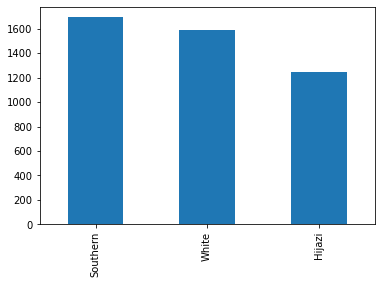

In [53]:
ax = data["dialect"].value_counts(dropna=False).plot(kind='bar')
ax.set_xticklabels(["Southern", "White", "Hijazi"]);

## Modelling

**Why no stemming, lemmatization and stop words?**
1. stemming, lemmatization are only available for formal Arabic.
2. stop words are important to identify dialects: usually هذا، هاذا، هادا etc is ignored.

In [55]:
# Splitting the data
X = data['Embedded_text']
y = data['dialect']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 123)

In [56]:
# Tokenizing labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [57]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 100 # avg tweet has < 100 words

# Tokenizing text
tokenizer = Tokenizer(oov_token='<OOV>') # fill in words absent from corpus with <OOV> to keep text length
tokenizer.fit_on_texts(X_train)

# representing each text as a sequence of tokens
train_sequence = tokenizer.texts_to_sequences(X_train)

# padding each sequence with trailing zeros so that all sequence have same length
train_pad = pad_sequences(train_sequence, maxlen=max_length, padding='post', truncating='post')

test_sequence = tokenizer.texts_to_sequences(X_test)
test_pad = pad_sequences(test_sequence, maxlen=max_length, padding='post', truncating='post')

In [58]:
# Most used words in all text
dict(list(tokenizer.word_index.items())[0:10])

{'<OOV>': 1,
 'من': 2,
 'اله': 3,
 'في': 4,
 'الهم': 5,
 'على': 6,
 'الي': 7,
 'كل': 8,
 'ه': 9,
 'بس': 10}

In [59]:
# Defining hyperparamerts
epochs = 10
n_dim = 16
training_size = X_train.shape[0]
vocab_size = len(tokenizer.word_index) + 1 # zero indexed
embedding_dim = 64

In [60]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax'),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          704128    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 770,563
Trainable params: 770,563
Non-trainable params: 0
_________________________________________________________________


In [61]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_pad, y_train, epochs=epochs, validation_data=(test_pad, y_test), verbose=2)

Epoch 1/10
114/114 - 14s - loss: 1.0174 - accuracy: 0.4666 - val_loss: 0.9266 - val_accuracy: 0.5563 - 14s/epoch - 121ms/step
Epoch 2/10
114/114 - 9s - loss: 0.6406 - accuracy: 0.7457 - val_loss: 0.7239 - val_accuracy: 0.7053 - 9s/epoch - 81ms/step
Epoch 3/10
114/114 - 9s - loss: 0.2604 - accuracy: 0.9117 - val_loss: 0.8475 - val_accuracy: 0.6887 - 9s/epoch - 76ms/step
Epoch 4/10
114/114 - 8s - loss: 0.1342 - accuracy: 0.9602 - val_loss: 0.9004 - val_accuracy: 0.6909 - 8s/epoch - 69ms/step
Epoch 5/10
114/114 - 8s - loss: 0.0761 - accuracy: 0.9785 - val_loss: 0.9417 - val_accuracy: 0.6865 - 8s/epoch - 72ms/step
Epoch 6/10
114/114 - 9s - loss: 0.0604 - accuracy: 0.9804 - val_loss: 1.1288 - val_accuracy: 0.6700 - 9s/epoch - 79ms/step
Epoch 7/10
114/114 - 9s - loss: 0.0517 - accuracy: 0.9843 - val_loss: 0.9937 - val_accuracy: 0.6876 - 9s/epoch - 78ms/step
Epoch 8/10
114/114 - 13s - loss: 0.0463 - accuracy: 0.9862 - val_loss: 1.0746 - val_accuracy: 0.6810 - 13s/epoch - 117ms/step
Epoch 9/10

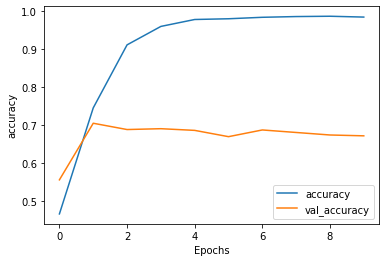

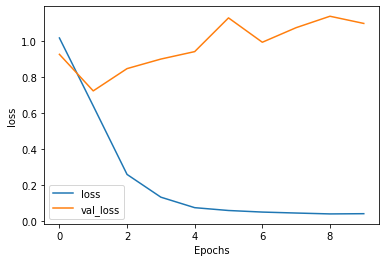

In [62]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Althrough we got a high accuracy, the validation accuracy is much lower which indicates an overfit model.

## Assumptions and Limitations
1. Input text will be clean from other languages text or emojis
2. For the input text to be classified accurately it should use same spelling used in training text

## Future development
1. Increase dataset size
2. Manually check every entry
3. Deploy the model

## Conclusion
Classifying an Arabic text and especially non formal Arabic is still a challenge due to the lack of tools and resources. Having it would make the process much smoother and yeilds overall better results.

## Source Code
This report is hosted on Github Pages and the repo can be accessed via [this link](https://github.com/Turkinass/Saudi_Dialects_Classifier).